# Guassian mixture intra-song clustering for identification of "main" beats

Code for embedding and testing

In [ ]:
# Tried to optimize bar embedding code but didn't finish
def bar_embedding_opt(data,dbeats,bar_num,dimension,framerate,kernel=None, kernel_width=1):
    assert bar_num < len(dbeats), 'bar_num must be smaller than the number of bars in the audio'

    time_interval = (dbeats[bar_num-1],dbeats[bar_num])
    frame_interval = (int(time_interval[0]*framerate), int(time_interval[1]*framerate))

    sub_beats = np.round(np.linspace(frame_interval[0],frame_interval[1],dimension+1))
    sub_beat_interval = int(sub_beats[1] - sub_beats[0])

    # Shape: (measures, )
    frame_starts = (dbeats[:-1] * framerate).astype(int)
    frame_ends = (dbeats[1:] * framerate).astype(int)
    # Shape: (measures, dimension + 1)
    sub_beats = np.round(np.linspace(frame_starts, frame_ends, dimension+1, axis=1))
    # Shape: (measures, dimension)
    sub_beat_intervals = sub_beats[1:] - sub_beats[:-1]


    kernel_sigma = kernel_width * sub_beat_intervals
    kernel = np.exp(-np.arange(-sub_beat_interval,sub_beat_interval,1)**2/(2*kernel_sigma**2))
    kernel = kernel / np.sum(kernel)
    # print(kernel.shape)
    
    sub_beat_data = np.zeros(dimension) # we do not want to count down beat twice
    sub_data = np.zeros((dimension, 2*sub_beat_interval))

    for i in range(dimension):
        # getting data around subbeat[i] of length 2*sub_beat_length
        start = int(sub_beats[i]-sub_beat_interval)
        end = int(sub_beats[i]+sub_beat_interval)
        sub_data[i, -sub_beat_interval:sub_beat_interval] = data[max(start, 0):min(end, len(data))]


    sub_data = sub_data**2
    return np.sum(kernel * (sub_data), axis=1)

In [75]:
%load_ext autoreload
%autoreload 2


def do_component_statistics_test(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts



from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices

def do_projected_plot_test(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")


    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=0.9, pts=data, pca=pca)

    plt.figure()
    ax = plt.gca()
    ax.set_xlim([-.2, .2])
    ax.set_ylim([-.2, .2])


    plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    for p in patches:
        ax.add_patch(p)

    return gm, pca


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the file and process data using the embedding

In [79]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
#from groove.embedding import beat_frames_to_toy
import numpy as np
from groove.embedding import bar_embedding, load_bar_embedding

#file = "milaklaw"
#ext= "mp3"

#file = '03 All the Pretty Girls'
#ext = 'm4a'

#file = '09 D\'Angelo - Spanish Joint'
#ext = 'm4a'

#file = '06 Encore A'
#ext = 'mp3'

#file = 'lms'
#ext='mp3'

#data = load_bar_embedding('lms', smooth_power, 'mp3')


data_mk = load_bar_embedding('milaklaw', divisions=[4, 8, 16], weights=[1, .5, .25], process=smooth_power)
data_e = load_bar_embedding('06 Encore A', divisions=[4, 8, 16], weights=[1, .5, .25], process=smooth_power)
data = np.concatenate([data_mk, data_e], axis=0)


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

First, get some statistics on the number of components.

In [47]:
do_component_statistics_test(data, 10)


# TODO: possible way to improve the alg: do some number of trials to determine number of components based on how "stable" it is, then run it for that number?
# TODO: or, pick the lowest that isn't an outlier?  lower tends to be better
# TODO: also, can take the average of the means?


{1: 10}

For visualization, PCA the top two components and project the clusters down

Weights: [0.37949894 0.62050106]
PCA values: [0.55142341 0.18320535]


array([[ 0.03394182,  0.00216968],
       [-0.02075884, -0.00132698]])

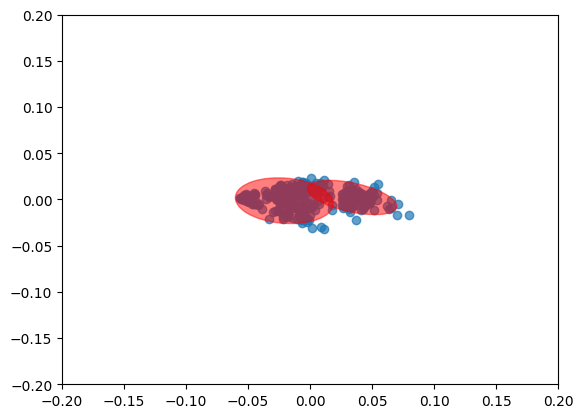

In [82]:
gm, pca = do_projected_plot_test(data, confidence_limit=0.75, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False)
(gm.means_ - pca.mean_) @ pca.components_.T

Pick the measures closest to the means of each cluster and play the audio.

In [83]:
inds = find_closest_indices(gm.means_, data)
do_bar_sample(inds, file, smooth_power, ext)

IndexError: list index out of range

[ 79 252]


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


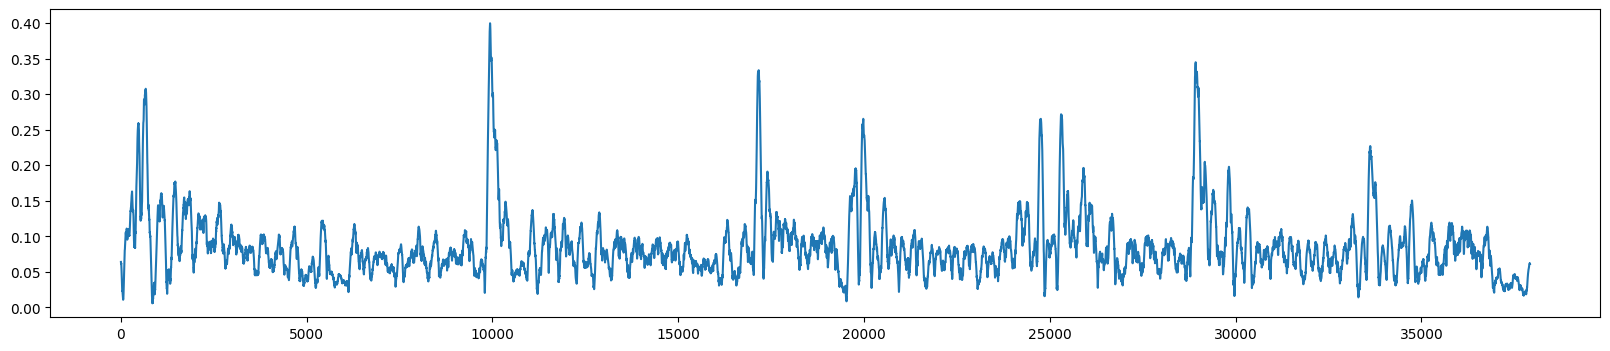

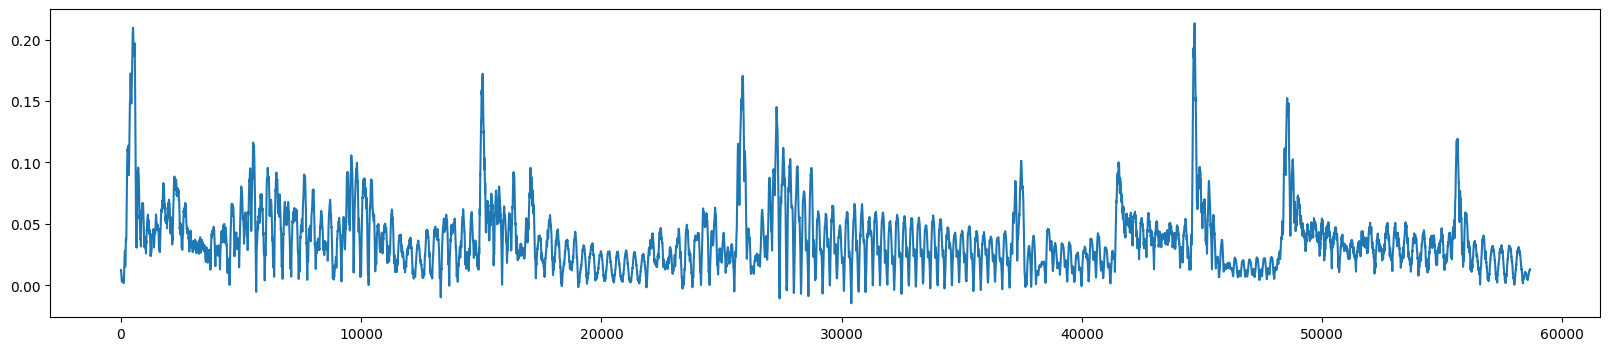

In [84]:
inds = find_closest_indices(gm.means_, data)
print(inds)
do_bar_sample(inds[inds < data_mk.shape[0]], 'milaklaw', smooth_power)
do_bar_sample(inds[inds >= data_mk.shape[0]] - data_mk.shape[0], '06 Encore A', smooth_power)